Classifying Tiny ImageNet [computer vision in SNU]
============

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import caffe
from tiny_util import get_synset_words

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
synset_dic = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# synset_dic = get_synset_words()
DATA_PATH = '../data/tiny-imagenet-200'
# MODEL_FILE = '../models/our_tinyimagenet_caffenet/deploy.prototxt'
# PRETRAINED = '../models/our_tinyimagenet_caffenet/caffenet_train.caffemodel'
MODEL_FILE = '../models/bvlc_reference_caffenet/deploy.prototxt'
PRETRAINED = '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
IMAGE_FILE = 'images/cat.jpg'
IMAGE_FILE2 = 'images/fish-bike.jpg'
caffe_root = '../'

In [17]:
# caffe.set_mode_cpu()
caffe.set_mode_gpu()

# caffe.Classifier Takes Everything!
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       # mean subtraction 을 함
                       channel_swap=(2,1,0),
                       # RGB order 를 bvlc_reference_caffenet.caffemodel 에서 요구하는 BGR 순서로 바꿈
                       raw_scale=255,
                       # pixel value [0, 255]를 [0, 1]으로 scaling 함
                       image_dims=(256, 256)
                       # input 이미지 사이즈 설정
                      )

In [18]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

### show begin

In [19]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [20]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

Top0: n02356798 fox squirrel, eastern fox squirrel, Sciurus niger
Top1: n04443257 tobacco shop, tobacconist shop, tobacconist
Top2: n07932039 eggnog
Top3: n03920288 Petri dish
Top4: n02794156 barometer


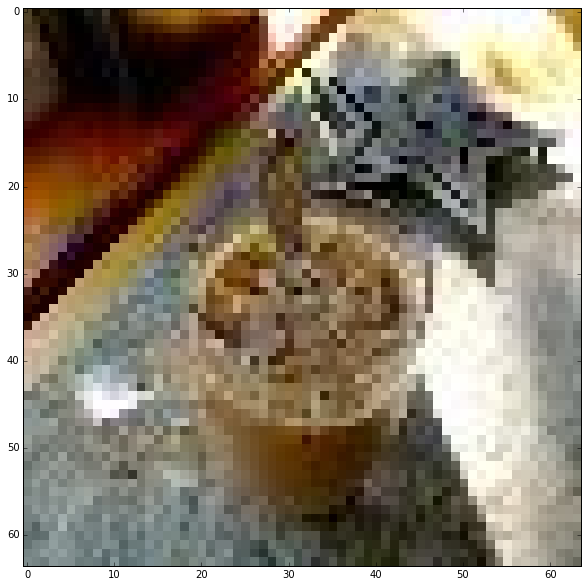

In [44]:
# test (novel images)

for n in range(80, 81):
    img = caffe.io.load_image(DATA_PATH + '/test/images/test_{}.JPEG'.format(n))
    plt.imshow(img)
    prediction = net.predict([img], oversample=True)
    for i, label in enumerate(prediction[0].argsort()[-1:-6:-1]):
        print "Top{0}: {1}".format(i, synset_dic[label])

(2, 1000)


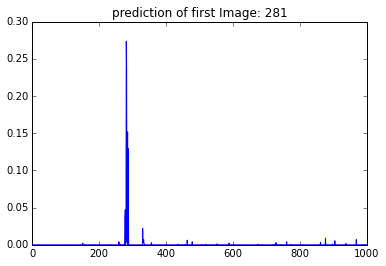

In [58]:
# Oversampling? The default is to actually do 10 predictions, 
# cropping the center and corners of the image as well as their mirrored versions, 
# and average over the predictions
# Note that if we use oversample=False, it makes a single input, 
# although if you inspect the model definition prototxt you'll see the network has a batch size of 10. 
# The python wrapper handles batching and padding for you!

prediction = net.predict([input_image, input_image2], oversample=True)
print prediction.shape
plt.title("prediction of first Image: {}".format(prediction[0].argmax()))
plt.plot(prediction[0])

In [60]:
# TEST FOR TIME
# Resize the image to the standard (256, 256) and oversample net input sized crops.
input_oversampled = caffe.io.oversample([caffe.io.resize_image(input_image, net.image_dims)], net.crop_dims)
# 'data' is the input blob name in the model definition, so we preprocess for that input.
caffe_input = np.asarray([net.transformer.preprocess('data', in_) for in_ in input_oversampled])
%timeit net.predict([input_image])        # 10 loops, best of 3: 174 ms per loop [benchmark]
%timeit net.forward(data=caffe_input)  # 10 loops, best of 3: 34.2 ms per loop [benchmark]

10 loops, best of 3: 35.7 ms per loop
10 loops, best of 3: 20.2 ms per loop


In [4]:
# The first layer filters, conv1
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

NameError: name 'net' is not defined

In [5]:
# The first layer output, conv1 (rectified responses of the filters above, first 36 only)
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

NameError: name 'net' is not defined

In [6]:
# The second layer filters, conv2
# There are 256 filters, each of which has dimension 5 x 5 x 48. 
# We show only the first 48 filters, with each channel shown separately, so that each filter is a row.
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

NameError: name 'net' is not defined

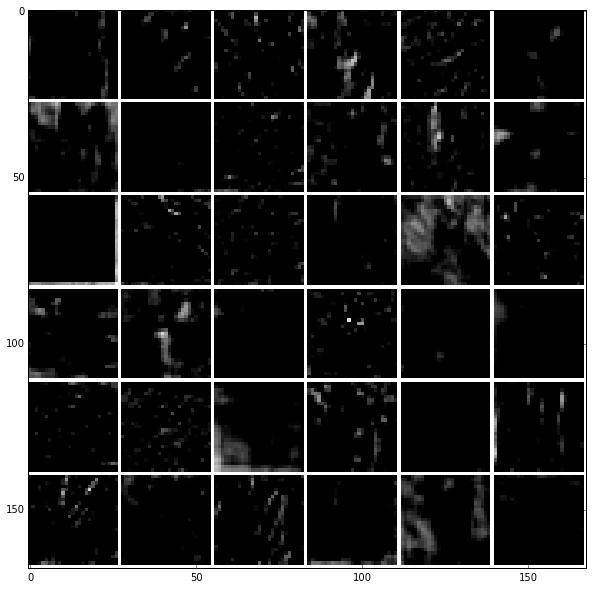

In [77]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

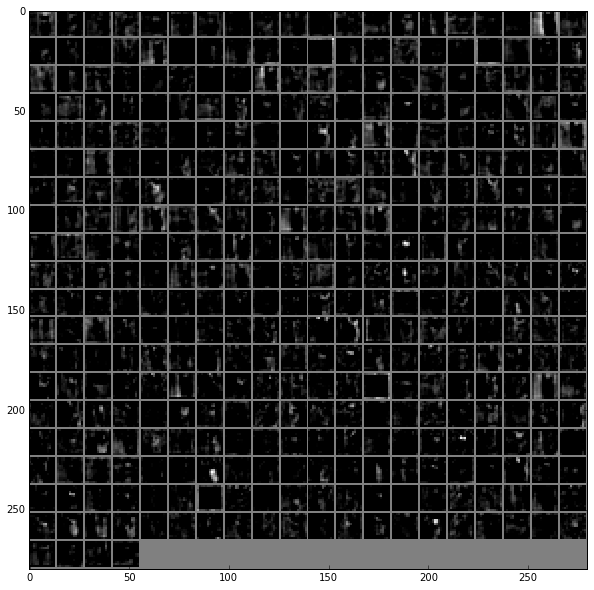

In [78]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

Parting Words
-------------

So this is python! We hope the interface is easy enough for one to use. The python wrapper is interfaced with boost::python, and source code can be found at `python/caffe` with the main interface in `pycaffe.py` and the classification wrapper in `classifier.py`. If you have customizations to make, start there! Do let us know if you make improvements by sending a pull request!